## EN2550 Assignment 1 on Fitting and Alignment

190574U </br> Induwara Senadheera

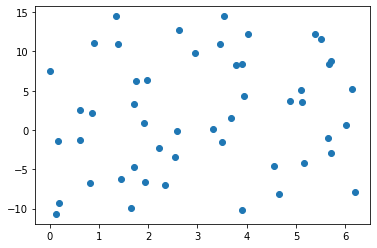

In [7]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

fig,ax=plt.subplots()

plt.scatter(t,y)